In [1]:
%matplotlib inline


Example demonstrating STAR + DSS
================================

This example shows how one can effectively combine STAR and DSS to recover
signal components which would not have been discoverable with either these
two techniques alone, due to the presence of strong artifacts.

This example replicates figure 1 in [1]_.

References
----------
.. [1] de Cheveigné A (2016) Sparse Time Artifact Removal, Journal of
   Neuroscience Methods, 262, 14-20, doi:10.1016/j.jneumeth.2016.01.005




In [2]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import leastsq

from meegkit import star, dss
from meegkit.utils import demean, normcol, tscov

import config  # noqa

np.random.seed(9)

Create simulated data
-----------------------------------------------------------------------------
Simulated data consist of N channels, 1 sinusoidal target, N-3 noise sources,
with temporally local artifacts on each channel.



In [3]:
# Source
n_chans, n_samples = 10, 1000
f = 2
target = np.sin(np.arange(n_samples) / n_samples * 2 * np.pi * f)
target = target[:, np.newaxis]
noise = np.random.randn(n_samples, n_chans - 3)

# Create artifact signal
SNR = np.sqrt(1)
x0 = (normcol(np.dot(noise, np.random.randn(noise.shape[1], n_chans))) +
      SNR * target * np.random.randn(1, n_chans))
x0 = demean(x0)
artifact = np.zeros(x0.shape)
for k in np.arange(n_chans):
    artifact[k * 100 + np.arange(20), k] = 1
x = x0 + 10 * artifact


def _sine_fit(x):
    """Fit a sinusoidal trend."""
    guess_mean = np.mean(x)
    guess_std = np.std(x)
    guess_phase = 0
    t = np.linspace(0, 4 * np.pi, x.shape[0])

    # Optimization function, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    def func(y):
        return np.mean(x - (y[0] * np.sin(t + y[1]) + y[2])[:, None], 1)

    est_std, est_phase, est_mean = leastsq(
        func, [guess_std, guess_phase, guess_mean])[0]
    data_fit = est_std * np.sin(t + est_phase) + est_mean
    return np.tile(data_fit, (x.shape[1], 1)).T

1) Apply STAR
-----------------------------------------------------------------------------



In [4]:
y, w, _ = star.star(x, 2)

proportion artifact free: 0.70
proportion artifact free: 0.70
proportion artifact free: 0.70
depth: 1
fixed channels: 10
fixed samples: 299
ratio: 1.01
power ratio: 0.43


/Users/nicolas/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/nicolas/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/nicolas/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`.

2) Apply DSS on raw data
-----------------------------------------------------------------------------



In [5]:
c0, _ = tscov(x)
c1, _ = tscov(x - _sine_fit(x))
[todss, _, pwr0, pwr1] = dss.dss0(c0, c1)
z1 = normcol(np.dot(x, todss))

3) Apply DSS on STAR-ed data
-----------------------------------------------------------------------------
Here the bias function is the original signal minus the sinusoidal trend.



In [6]:
c0, _ = tscov(y)
c1, _ = tscov(y - _sine_fit(y))
[todss, _, pwr0, pwr1] = dss.dss0(c0, c1)
z2 = normcol(np.dot(y, todss))

Plots
-----------------------------------------------------------------------------



/Users/nicolas/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


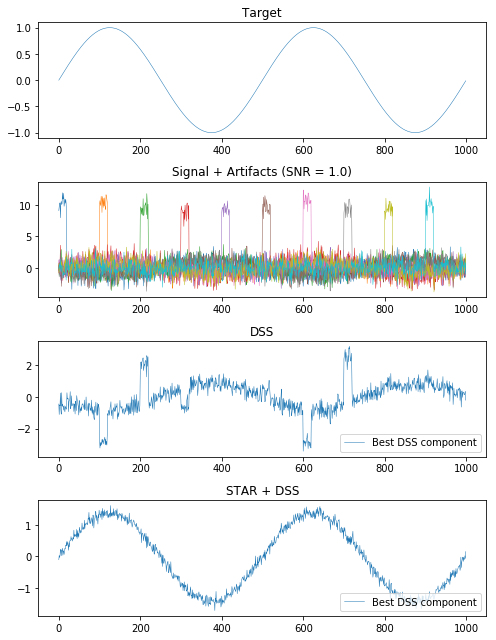

In [7]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(7, 9))
ax0.plot(target, lw=.5)
ax0.set_title('Target')

ax1.plot(x, lw=.5)
ax1.set_title('Signal + Artifacts (SNR = {})'.format(SNR))

ax2.plot(z1[:, 0], lw=.5, label='Best DSS component')
ax2.set_title('DSS')
ax2.legend(loc='lower right')

ax3.plot(z2[:, 0], lw=.5, label='Best DSS component')
ax3.set_title('STAR + DSS')
ax3.legend(loc='lower right')

f.set_tight_layout(True)
plt.show()